In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

# Load the dataset (assuming it's already loaded as a DataFrame named `data`)
data = pd.read_csv(os.path.join(os.getcwd(), "../../data/for_lstm1.csv"), index_col=0)

# Fill missing values - you can decide to use forward fill, backward fill, or interpolation
data.dropna(inplace=True)
# Select the features you want to use
features = ['open', 'high', 'low', 'close', 'volume_krw', 'price_pct_change', 
            'volume__pct_change', 'ma_5', 'ma_50', 'mmt_120_score', 'rsi']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # '3' corresponds to the 'close' price in the features list
    return np.array(x), np.array(y)

seq_length = 7  # Number of previous days to consider for predicting the next day
x, y = create_sequences(scaled_data, seq_length)
# print(x, y)

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer to output the prediction
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Model parameters
input_size = len(features)  # Number of features
hidden_size = 64  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
output_size = 1  # We are predicting one value (the next close price)

model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer with a lower learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop with gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(x_train)
    optimizer.zero_grad()
    
    # Calculate the loss
    loss = criterion(outputs, y_train)
    
    # Backpropagation and optimization
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation mode
model.eval()
with torch.no_grad():
    predicted_prices = model(x_test).detach().numpy()

# Reverse the scaling for better interpretability
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices), 3)), 
                                                           predicted_prices, 
                                                           np.zeros((len(predicted_prices), 7))), axis=1))[:, 3]
actual_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 3)), 
                                                        y_test.numpy().reshape(-1, 1), 
                                                        np.zeros((len(y_test), 7))), axis=1))[:, 3]

# Plot the actual vs predicted prices
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

      day_starting_at_4am        open        high         low       close  \
120   2021-07-29 04:00:00  46702000.0  47000000.0  45529000.0  45659000.0   
121   2021-07-30 04:00:00  45659000.0  46400000.0  44450000.0  45347000.0   
122   2021-07-31 04:00:00  45346000.0  48768000.0  45341000.0  47972000.0   
123   2021-08-01 04:00:00  47972000.0  49471000.0  47400000.0  47688000.0   
124   2021-08-02 04:00:00  47744000.0  48157000.0  45438000.0  45951000.0   
...                   ...         ...         ...         ...         ...   
1232  2024-08-14 04:00:00  84725000.0  85950000.0  82483000.0  82732000.0   
1233  2024-08-15 04:00:00  82732000.0  83555000.0  81048000.0  81437000.0   
1234  2024-08-16 04:00:00  81436000.0  83040000.0  79500000.0  82912000.0   
1235  2024-08-17 04:00:00  82911000.0  83400000.0  82042000.0  82766000.0   
1236  2024-08-18 04:00:00  82766000.0  83679000.0  82500000.0  82931000.0   

        volume_krw  volume_market  price_pct_change  volume__pct_change  \


Epoch [10/200], Loss: 0.0266
Epoch [20/200], Loss: 0.0154
Epoch [30/200], Loss: 0.0040
Epoch [40/200], Loss: 0.0028
Epoch [50/200], Loss: 0.0016
Epoch [60/200], Loss: 0.0013
Epoch [70/200], Loss: 0.0011
Epoch [80/200], Loss: 0.0010
Epoch [90/200], Loss: 0.0009
Epoch [100/200], Loss: 0.0008
Epoch [110/200], Loss: 0.0008
Epoch [120/200], Loss: 0.0007
Epoch [130/200], Loss: 0.0007
Epoch [140/200], Loss: 0.0006
Epoch [150/200], Loss: 0.0006
Epoch [160/200], Loss: 0.0005
Epoch [170/200], Loss: 0.0005
Epoch [180/200], Loss: 0.0005
Epoch [190/200], Loss: 0.0004
Epoch [200/200], Loss: 0.0004


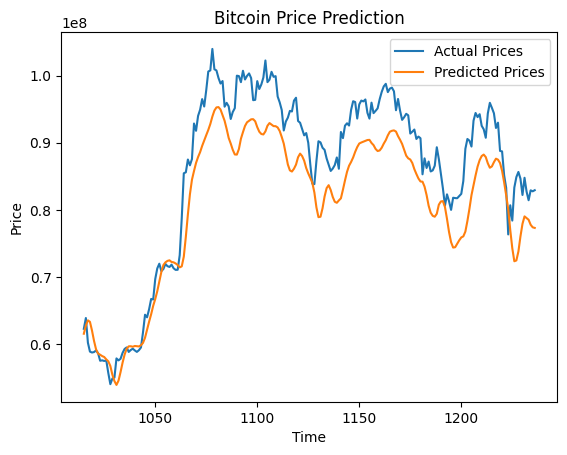

   Date        Actual     Predicted
0  1015  6.229500e+07  6.156186e+07
1  1016  6.390000e+07  6.276523e+07
2  1017  6.022700e+07  6.355695e+07
3  1018  5.889700e+07  6.333557e+07
4  1019  5.876300e+07  6.204582e+07


In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
import os

# Load the dataset (assuming it's already loaded as a DataFrame named `data`)
data = pd.read_csv(os.path.join(os.getcwd(), "../../data/for_lstm1.csv"), index_col=0)

# Fill missing values - you can decide to use forward fill, backward fill, or interpolation
data.dropna(inplace=True)

# Select the features you want to use
features = ['open', 'high', 'low', 'close', 'volume_krw', 'price_pct_change', 
            'volume__pct_change', 'ma_5', 'ma_50', 'mmt_120_score', 'rsi']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # '3' corresponds to the 'close' price in the features list
    return np.array(x), np.array(y)

seq_length = 7  # Number of previous days to consider for predicting the next day
x, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer to output the prediction
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Model parameters
input_size = len(features)  # Number of features
hidden_size = 64  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
output_size = 1  # We are predicting one value (the next close price)

model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer with a lower learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop with gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(x_train)
    optimizer.zero_grad()
    
    # Calculate the loss
    loss = criterion(outputs, y_train)
    
    # Backpropagation and optimization
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation mode
model.eval()
with torch.no_grad():
    predicted_prices = model(x_test).detach().numpy()

# Reverse the scaling for better interpretability
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices), 3)), 
                                                           predicted_prices, 
                                                           np.zeros((len(predicted_prices), 7))), axis=1))[:, 3]
actual_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 3)), 
                                                        y_test.numpy().reshape(-1, 1), 
                                                        np.zeros((len(y_test), 7))), axis=1))[:, 3]

# Create a DataFrame to hold the actual and predicted prices
test_dates = data.index[-len(actual_prices):]  # Get the dates for the test set
result_df = pd.DataFrame({'Date': test_dates, 'Actual': actual_prices, 'Predicted': predicted_prices})

# Plot the actual vs predicted prices
plt.plot(result_df['Date'], result_df['Actual'], label='Actual Prices')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

# Optionally, save the results to a CSV file
result_df.to_csv("predicted_vs_actual.csv", index=False)

# Display the first few rows of the DataFrame
print(result_df.head())


Epoch [10/200], Loss: 0.0272
Epoch [20/200], Loss: 0.0225
Epoch [30/200], Loss: 0.0069
Epoch [40/200], Loss: 0.0042
Epoch [50/200], Loss: 0.0028
Epoch [60/200], Loss: 0.0017
Epoch [70/200], Loss: 0.0014
Epoch [80/200], Loss: 0.0012
Epoch [90/200], Loss: 0.0011
Epoch [100/200], Loss: 0.0010
Epoch [110/200], Loss: 0.0009
Epoch [120/200], Loss: 0.0008
Epoch [130/200], Loss: 0.0008
Epoch [140/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0007
Epoch [160/200], Loss: 0.0006
Epoch [170/200], Loss: 0.0006
Epoch [180/200], Loss: 0.0006
Epoch [190/200], Loss: 0.0005
Epoch [200/200], Loss: 0.0005


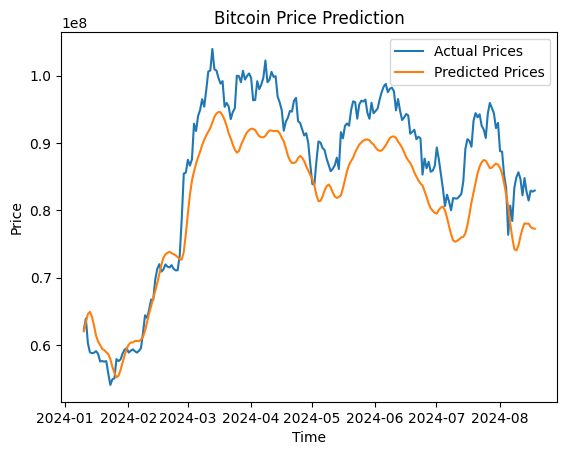

                 Date        Actual     Predicted
0 2024-01-10 04:00:00  6.229500e+07  6.202295e+07
1 2024-01-11 04:00:00  6.390000e+07  6.338069e+07
2 2024-01-12 04:00:00  6.022700e+07  6.457133e+07
3 2024-01-13 04:00:00  5.889700e+07  6.490569e+07
4 2024-01-14 04:00:00  5.876300e+07  6.415505e+07


In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
import os

# Load the dataset and parse dates
data = pd.read_csv(os.path.join(os.getcwd(), "../../data/for_lstm1.csv"), index_col=0, parse_dates=['day_starting_at_4am'])

# Fill missing values
data.dropna(inplace=True)

# Select the features you want to use
features = ['open', 'high', 'low', 'close', 'volume_krw', 'price_pct_change', 
            'volume__pct_change', 'ma_5', 'ma_50', 'mmt_120_score', 'rsi']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Function to create sequences of data for LSTM
def create_sequences(data, dates, seq_length):
    x, y, date_seqs = [], [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # '3' corresponds to the 'close' price in the features list
        date_seqs.append(dates[i+seq_length])  # Store the date corresponding to y
    return np.array(x), np.array(y), date_seqs

seq_length = 7  # Number of previous days to consider for predicting the next day
x, y, dates = create_sequences(scaled_data, data['day_starting_at_4am'].values, seq_length)

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, train_dates, test_dates = train_test_split(x, y, dates, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer to output the prediction
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Model parameters
input_size = len(features)  # Number of features
hidden_size = 64  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
output_size = 1  # We are predicting one value (the next close price)

model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer with a lower learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop with gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(x_train)
    optimizer.zero_grad()
    
    # Calculate the loss
    loss = criterion(outputs, y_train)
    
    # Backpropagation and optimization
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation mode
model.eval()
with torch.no_grad():
    predicted_prices = model(x_test).detach().numpy()

# Reverse the scaling for better interpretability
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices), 3)), 
                                                           predicted_prices, 
                                                           np.zeros((len(predicted_prices), 7))), axis=1))[:, 3]
actual_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 3)), 
                                                        y_test.numpy().reshape(-1, 1), 
                                                        np.zeros((len(y_test), 7))), axis=1))[:, 3]

# Create a DataFrame to hold the actual and predicted prices along with the dates
result_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual_prices,
    'Predicted': predicted_prices
})

# Plot the actual vs predicted prices
plt.plot(result_df['Date'], result_df['Actual'], label='Actual Prices')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

# Optionally, save the results to a CSV file
result_df.to_csv("predicted_vs_actual.csv", index=False)

# Display the first few rows of the DataFrame
print(result_df.head())


Epoch [10/200], Loss: 0.0365
Epoch [20/200], Loss: 0.0297
Epoch [30/200], Loss: 0.0277
Epoch [40/200], Loss: 0.0221
Epoch [50/200], Loss: 0.0055
Epoch [60/200], Loss: 0.0034
Epoch [70/200], Loss: 0.0021
Epoch [80/200], Loss: 0.0016
Epoch [90/200], Loss: 0.0014
Epoch [100/200], Loss: 0.0012
Epoch [110/200], Loss: 0.0011
Epoch [120/200], Loss: 0.0010
Epoch [130/200], Loss: 0.0010
Epoch [140/200], Loss: 0.0010
Epoch [150/200], Loss: 0.0009
Epoch [160/200], Loss: 0.0009
Epoch [170/200], Loss: 0.0009
Epoch [180/200], Loss: 0.0009
Epoch [190/200], Loss: 0.0009
Epoch [200/200], Loss: 0.0009


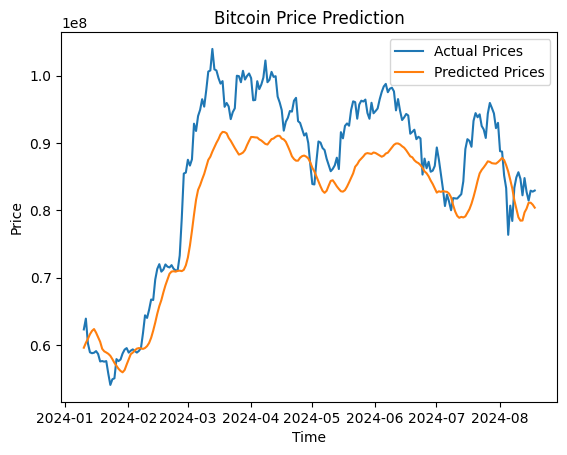

                 Date      Actual   Predicted
0 2024-01-10 04:00:00  62295004.0  59580276.0
1 2024-01-11 04:00:00  63900000.0  60300152.0
2 2024-01-12 04:00:00  60227004.0  60895500.0
3 2024-01-13 04:00:00  58897000.0  61580916.0
4 2024-01-14 04:00:00  58763000.0  62071108.0


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
import os

# Load the dataset and parse dates
data = pd.read_csv(os.path.join(os.getcwd(), "../../data/for_lstm1.csv"), index_col=0, parse_dates=['day_starting_at_4am'])

# Fill missing values
data.dropna(inplace=True)

# Use only the 'close' feature
features = ['close']

# Normalize the 'close' prices using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Function to create sequences of data for LSTM
def create_sequences(data, dates, seq_length):
    x, y, date_seqs = [], [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])  # Sequence of 'close' prices
        y.append(data[i+seq_length, 0])  # Predict the next 'close' price
        date_seqs.append(dates[i+seq_length])  # Store the date corresponding to y
    return np.array(x), np.array(y), date_seqs

seq_length = 7  # Number of previous days to consider for predicting the next day
x, y, dates = create_sequences(scaled_data, data['day_starting_at_4am'].values, seq_length)

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, train_dates, test_dates = train_test_split(x, y, dates, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer to output the prediction
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Model parameters
input_size = len(features)  # Number of features (1 for 'close')
hidden_size = 64  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
output_size = 1  # We are predicting one value (the next close price)

model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer with a lower learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop with gradient clipping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(x_train)
    optimizer.zero_grad()
    
    # Calculate the loss
    loss = criterion(outputs, y_train)
    
    # Backpropagation and optimization
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation mode
model.eval()
with torch.no_grad():
    predicted_prices = model(x_test).detach().numpy()

# Reverse the scaling for better interpretability
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.numpy())

# Create a DataFrame to hold the actual and predicted prices along with the dates
result_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual_prices.flatten(),  # Flatten to 1D array
    'Predicted': predicted_prices.flatten()  # Flatten to 1D array
})

# Plot the actual vs predicted prices
plt.plot(result_df['Date'], result_df['Actual'], label='Actual Prices')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

# Optionally, save the results to a CSV file
result_df.to_csv("predicted_vs_actual.csv", index=False)

# Display the first few rows of the DataFrame
print(result_df.head())


Epoch [10/100], Loss: 0.0007
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0002
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0003
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0001


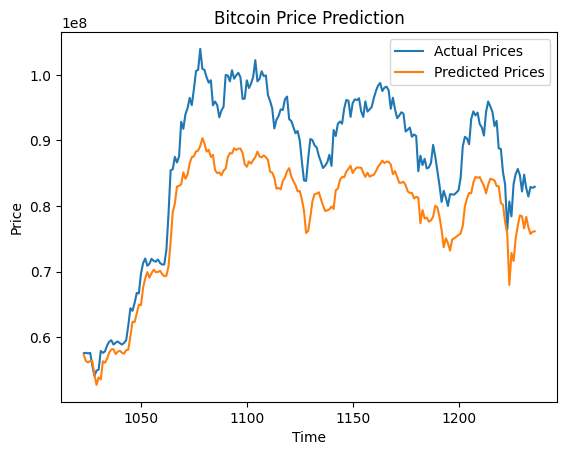

     Date        Actual     Predicted
209  1232  8.273200e+07  7.834520e+07
210  1233  8.143700e+07  7.676944e+07
211  1234  8.291200e+07  7.573305e+07
212  1235  8.276600e+07  7.606794e+07
213  1236  8.293100e+07  7.613644e+07


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import sys
import os

# Load the dataset (assuming it's already loaded as a DataFrame named `data`)
data = pd.read_csv(os.path.join(os.getcwd(), "../../data/for_lstm1.csv"), index_col=0)

# Fill missing values - you can decide to use forward fill, backward fill, or interpolation
data.dropna(inplace=True)

# Select the features you want to use
features = ['open', 'high', 'low', 'close', 'volume_krw', 'price_pct_change', 
            'volume__pct_change', 'ma_5', 'ma_50', 'mmt_120_score', 'rsi']

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

# Function to create sequences of data for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # '3' corresponds to the 'close' price in the features list
    return np.array(x), np.array(y)

seq_length = 50  # Number of previous days to consider for predicting the next day
x, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define batch size
batch_size = 64

# Create DataLoader for batching
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define a fully connected layer to output the prediction
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Model parameters
input_size = len(features)  # Number of features
hidden_size = 64  # Number of LSTM units
num_layers = 4  # Number of LSTM layers
output_size = 1  # We are predicting one value (the next close price)

model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer with a lower learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop with gradient clipping
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        outputs = model(inputs)
        optimizer.zero_grad()
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation and optimization
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation mode
model.eval()
with torch.no_grad():
    predicted_prices = model(x_test).detach().numpy()

# Reverse the scaling for better interpretability
predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices), 3)), 
                                                           predicted_prices, 
                                                           np.zeros((len(predicted_prices), 7))), axis=1))[:, 3]
actual_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 3)), 
                                                        y_test.numpy().reshape(-1, 1), 
                                                        np.zeros((len(y_test), 7))), axis=1))[:, 3]

# Create a DataFrame to hold the actual and predicted prices
test_dates = data.index[-len(actual_prices):]  # Get the dates for the test set
result_df = pd.DataFrame({'Date': test_dates, 'Actual': actual_prices, 'Predicted': predicted_prices})

# Plot the actual vs predicted prices
plt.plot(result_df['Date'], result_df['Actual'], label='Actual Prices')
plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

# Optionally, save the results to a CSV file
result_df.to_csv("predicted_vs_actual.csv", index=False)

# Display the first few rows of the DataFrame
print(result_df.tail())
